(interactive-analysis)=

# notebook: interactive analysis
One need for bioimage analysts is to interactively perform analysis on images. This interaction could be manual parameter tuning, such as adjusting thresholds, or performing human-in-the-loop analysis through clicking on specific regions of an image.

**[napari](https://napari.org/)** makes such interactive analyses easy because of its easy coupling with Python and the Scientific Python ecosystem, including tools like **[numpy](https://numpy.org/)** and **[scikit-image](https://scikit-image.org/)**.

## `Nebari` and `Binder` setup

In [1]:
# this cell is required to run these notebooks in the cloud. Make sure that you also have a desktop tab open.
import os
if 'BINDER_SERVICE_HOST' in os.environ or 'NEBARI_JUPYTERHUB_SSH_SERVICE_HOST' in os.environ:
    os.environ['DISPLAY'] = ':1.0'

## Getting started

We start by importing `napari`, our `nbscreenshot` utility and instantiating an empty viewer.

In [2]:
import napari
from napari.utils import nbscreenshot

# Create an empty viewer
viewer = napari.Viewer()

There are multiple ways of reading image data into napari: drag-and-drop, **File > Open**, or programmatic reading.  
For example, we could explicitly load a 3D image using the `tifffile` library and then use the `add_image()` method of our existing `Viewer` object named `viewer`. This approach allows you to load data into napari even if a Reader plugin doesn't exist for that file format!

```Python
import napari
from tifffile import imread

# load the image data using tifffile
nuclei = imread('data/nuclei.tif')
viewer.add_image(nuclei)
```

However, here, for simplicity, we will use the [`cells3d` dataset, provided by scikit-image](https://scikit-image.org/docs/stable/api/skimage.data.html#skimage.data.cells3d).

In [3]:
from skimage.data import cells3d

image_data = cells3d()  # shape (60, 2, 256, 256)

membranes = image_data[:, 0, :, :]
nuclei = image_data[:, 1, :, :]

Further, we will compute a maximum intensity projection of the nuclei data, reducing the dimensionality of the data from 3D to 2D, prior to adding the image to the viewer.

In [4]:
print('Shape of nuclei array: ', nuclei.shape)
# calculate max projection using numpy method
nuclei_mip = nuclei.max(axis=0)
print('Shape of max projection of nuclei: ', nuclei_mip.shape)

Shape of nuclei array:  (60, 256, 256)
Shape of max projection of nuclei:  (256, 256)


In [5]:
viewer.add_image(nuclei_mip)

<Image layer 'nuclei_mip' at 0x7ff8dc938bd0>

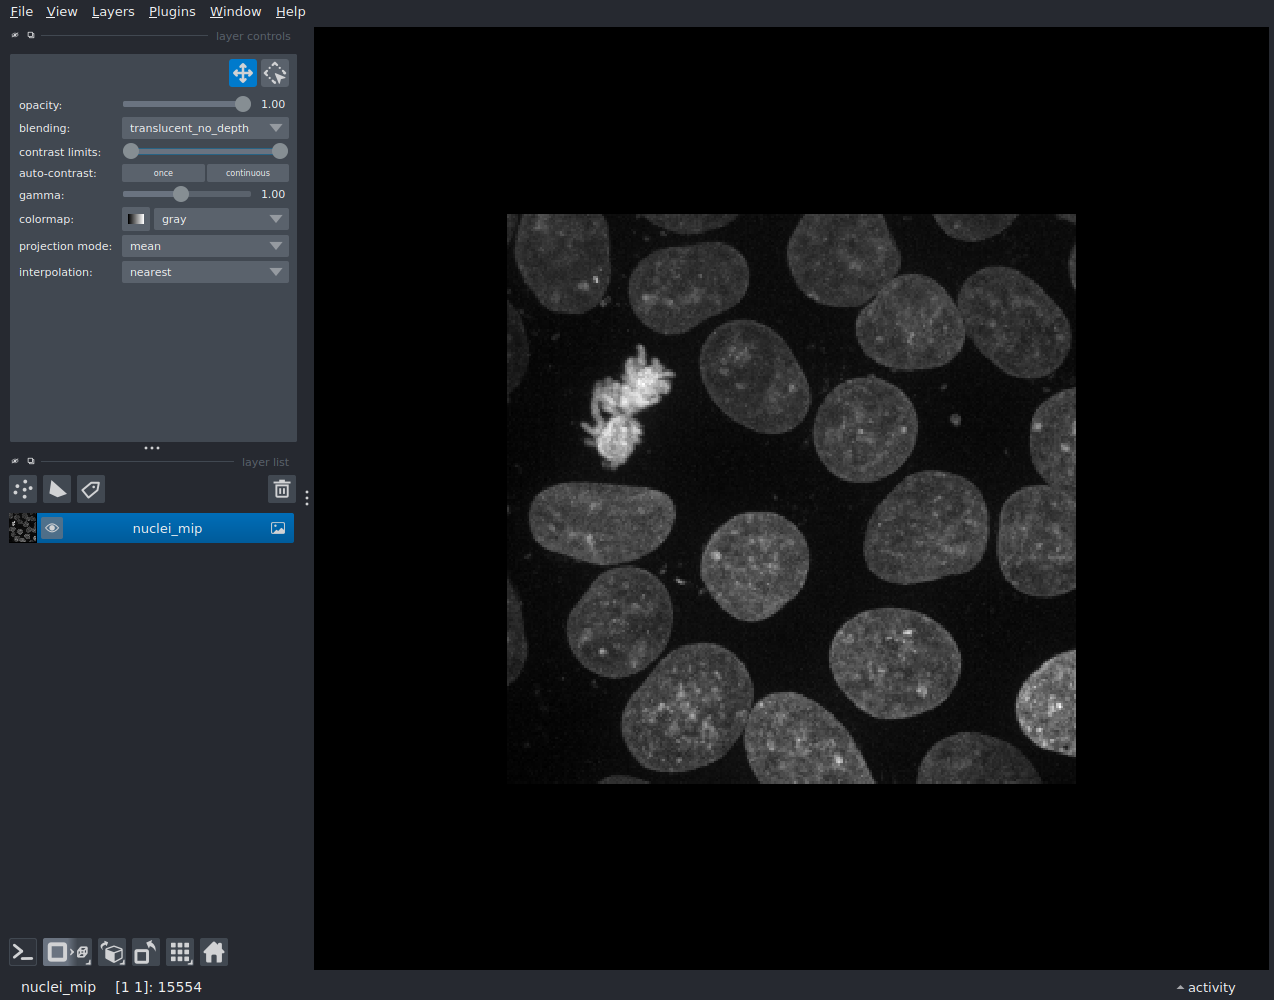

In [6]:
nbscreenshot(viewer)

## Visualizing image filtering results

One common task in image processing is **image filtering** which can be used to denoise an image or detect edges and other features.

We can use **napari** to visualize the results of some of the image filters that come with the **scikit-image** library.

In [7]:
# Import scikit-image's filtering module
from skimage import filters

In [8]:
viewer.add_image(filters.sobel_h(nuclei_mip), name='Horizontal Sobel')
viewer.add_image(filters.sobel_v(nuclei_mip), name='Vertical Sobel')
viewer.add_image(filters.roberts(nuclei_mip), name='Roberts')
viewer.add_image(filters.prewitt(nuclei_mip), name='Prewitt')
viewer.add_image(filters.scharr(nuclei_mip), name='Scharr')

<Image layer 'Scharr' at 0x7ff8d490ea90>

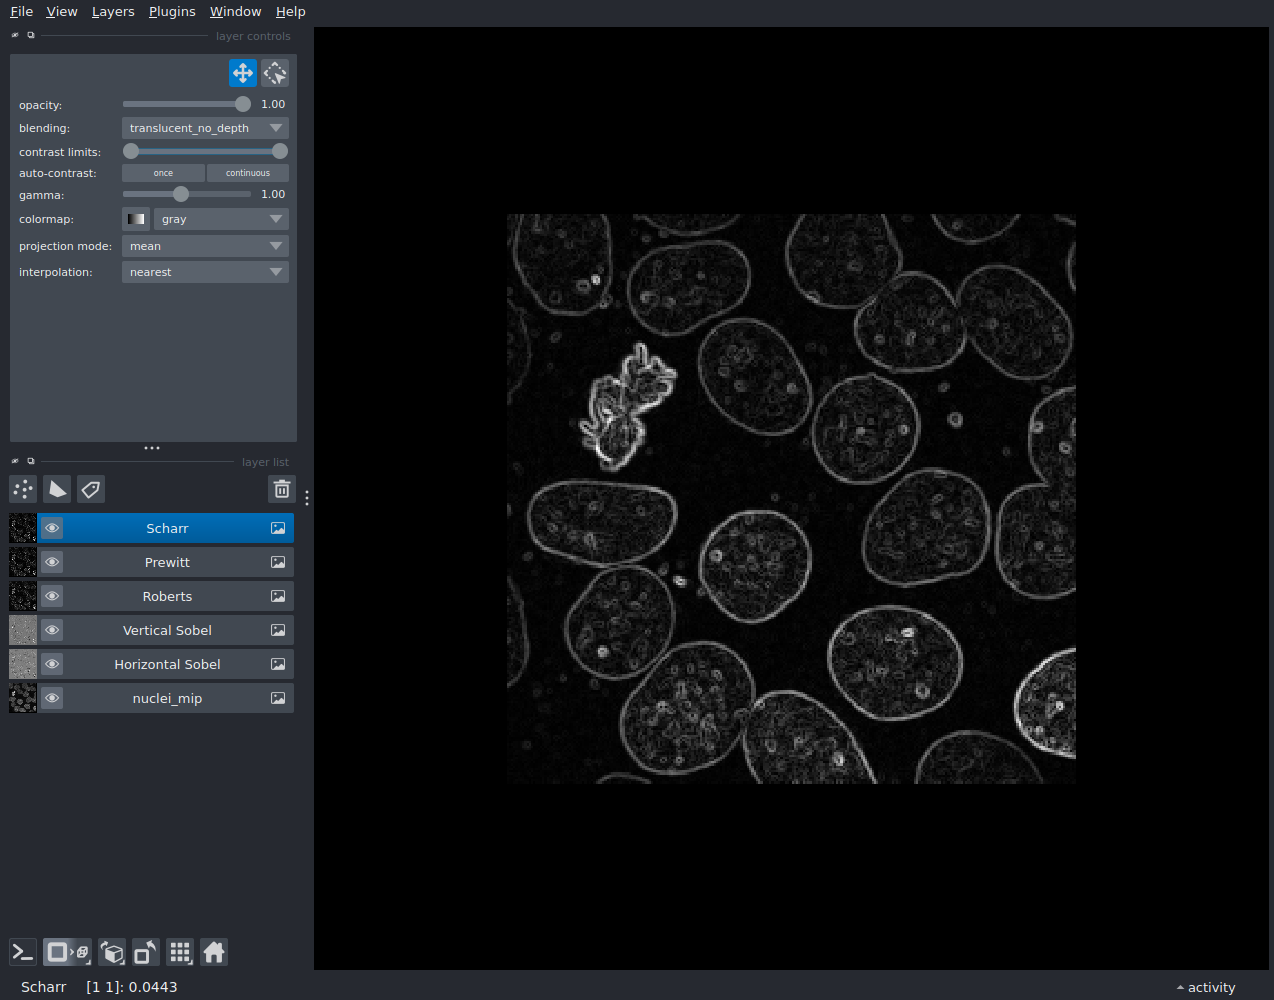

In [9]:
nbscreenshot(viewer)

In [10]:
# Remove all filter layers
for l in viewer.layers[1:]:
    viewer.layers.remove(l)

## Interactive segmentation
Let's now perform an interactive segmentation of the nuclei using processing utilities from `scikit-image`.

In [11]:
from skimage import morphology
from skimage import feature
from skimage import measure
from skimage import segmentation
from skimage import util 
from scipy import ndimage
import numpy as np

First, let's try and seperate background from foreground using a threshold. Here we'll use an automatically calculated threshold.

In [12]:
foreground = nuclei_mip >= filters.threshold_li(nuclei_mip)
viewer.add_labels(foreground, name='foreground')

<Labels layer 'foreground' at 0x7ff88c0fb3d0>

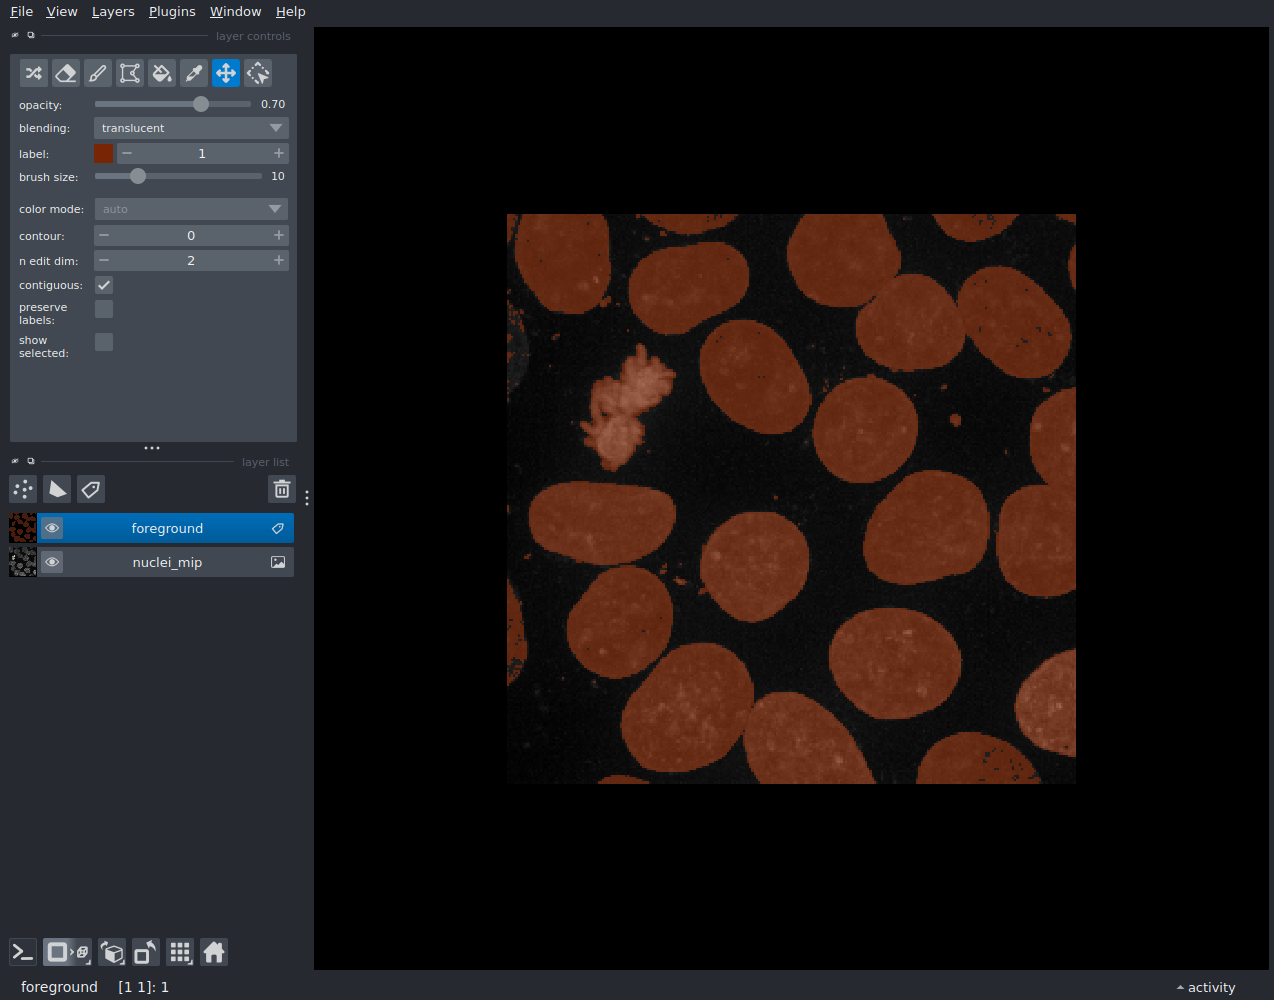

In [13]:
nbscreenshot(viewer)

Notice the debris located outside the nuclei and some of the holes located inside the nuclei. We will remove the debris by filtering out small objects, and fill the holes using a hole-filling algorithm. We can update the data of the layer in-place.

In [14]:
foreground_processed = morphology.remove_small_holes(foreground, 60)
foreground_processed = morphology.remove_small_objects(foreground_processed, min_size=50)

viewer.layers['foreground'].data = foreground_processed

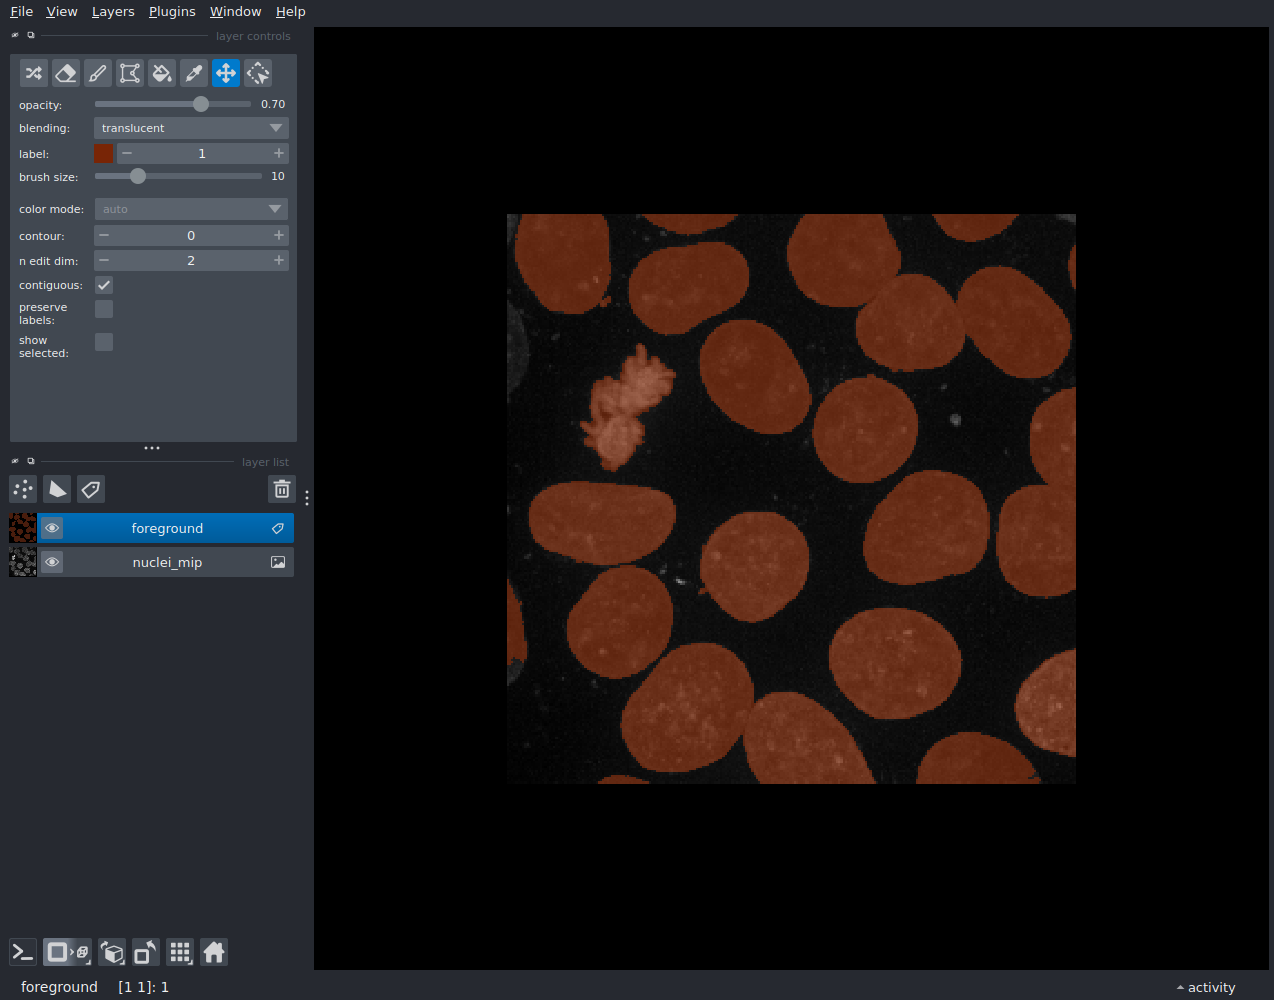

In [15]:
nbscreenshot(viewer)

We will now convert this binary mask into an **instance segmentation** where each nuclei is assigned a unique label.

We will do this using a **marker-controlled watershed** approach. The first step in this procedure is to calculate a distance transform on the binary mask as follows.

In [16]:
distance = ndimage.distance_transform_edt(foreground_processed)
viewer.add_image(distance)

<Image layer 'distance' at 0x7ff8dcd32250>

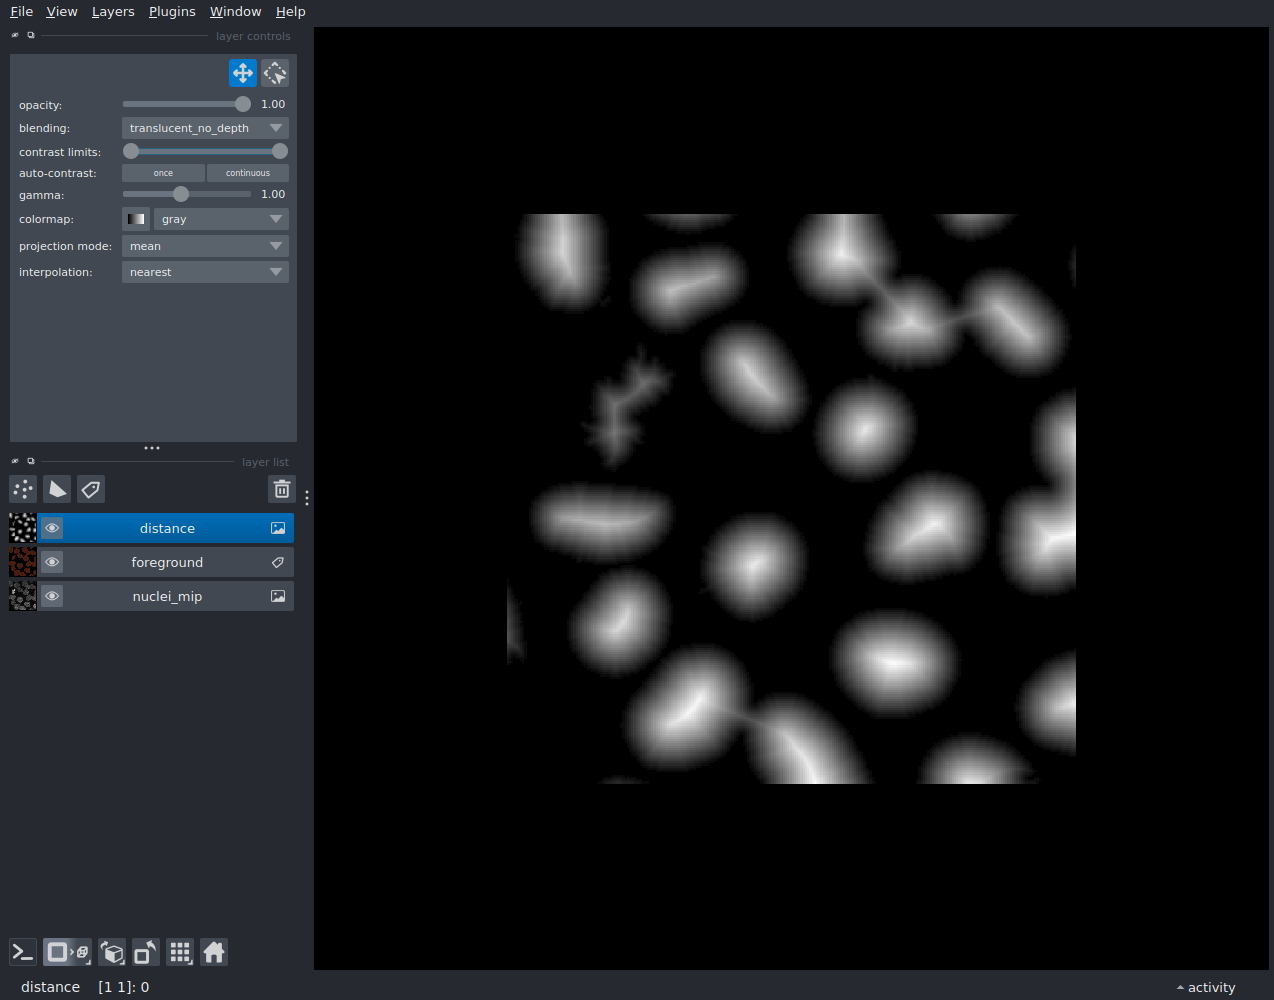

In [17]:
nbscreenshot(viewer)

We'll actually want to smooth the distance transform to avoid over-segmentation artifacts. We can do this on the layer data in-place.

In [18]:
smoothed_distance = filters.gaussian(distance, 10)
viewer.layers['distance'].data = smoothed_distance

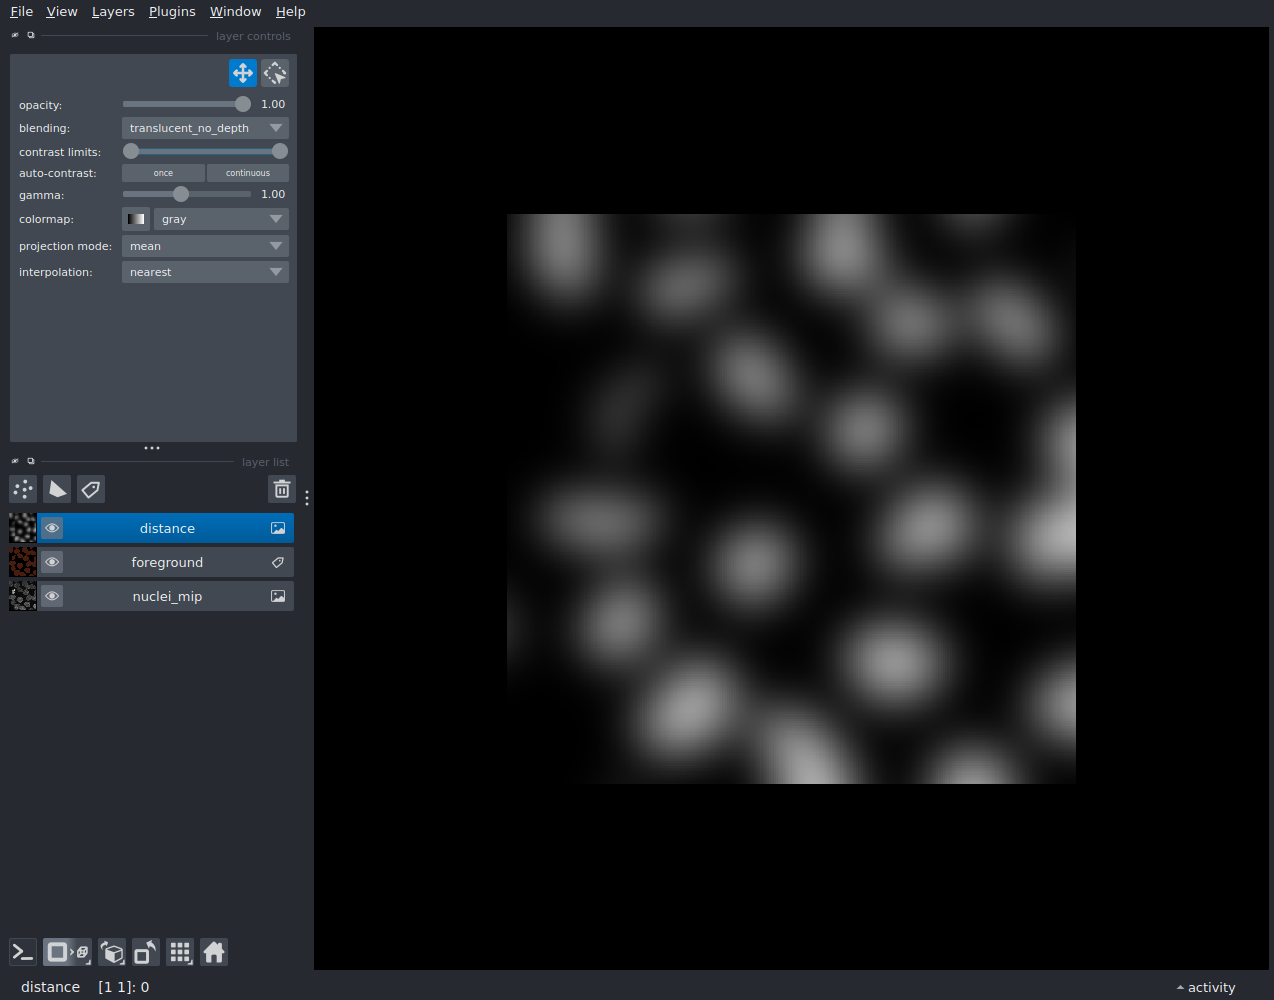

In [19]:
nbscreenshot(viewer)

Now we can try to identify the centers of each of the nuclei by finding peaks of the distance transform.

In [20]:
peak_local_max = feature.peak_local_max(
    smoothed_distance,
    min_distance=7,
    exclude_border=False
)

In [21]:
viewer.add_points(peak_local_max, name='peaks', size=5, face_color='red');

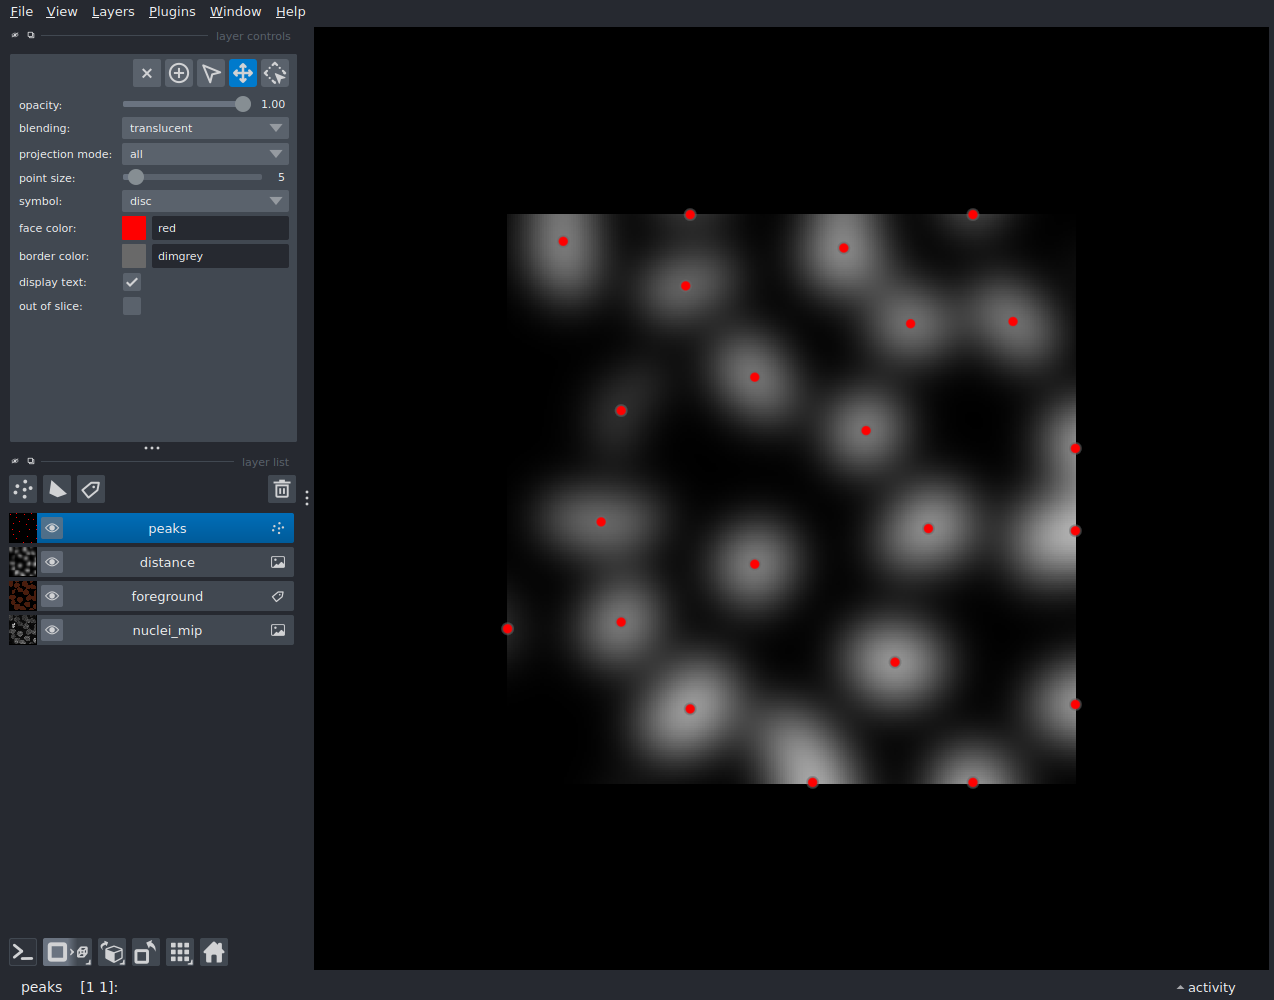

In [22]:
nbscreenshot(viewer)

We can now remove any of the points that don't correspond to nuclei centers, or add any new ones using the GUI.

In [23]:
viewer.layers['peaks'].selected_data = {11}
viewer.layers['peaks'].remove_selected()

Based on those peaks we can now seed the watershed algorithm which will find the nuclei boundaries.

In [24]:
markers = util.label_points(viewer.layers['peaks'].data, output_shape=viewer.layers['nuclei_mip'].data.shape)

nuclei_segmentation = segmentation.watershed(
    -smoothed_distance, 
    markers, 
    mask=foreground_processed
)

viewer.add_labels(nuclei_segmentation)

<Labels layer 'nuclei_segmentation' at 0x7ff878b70ed0>

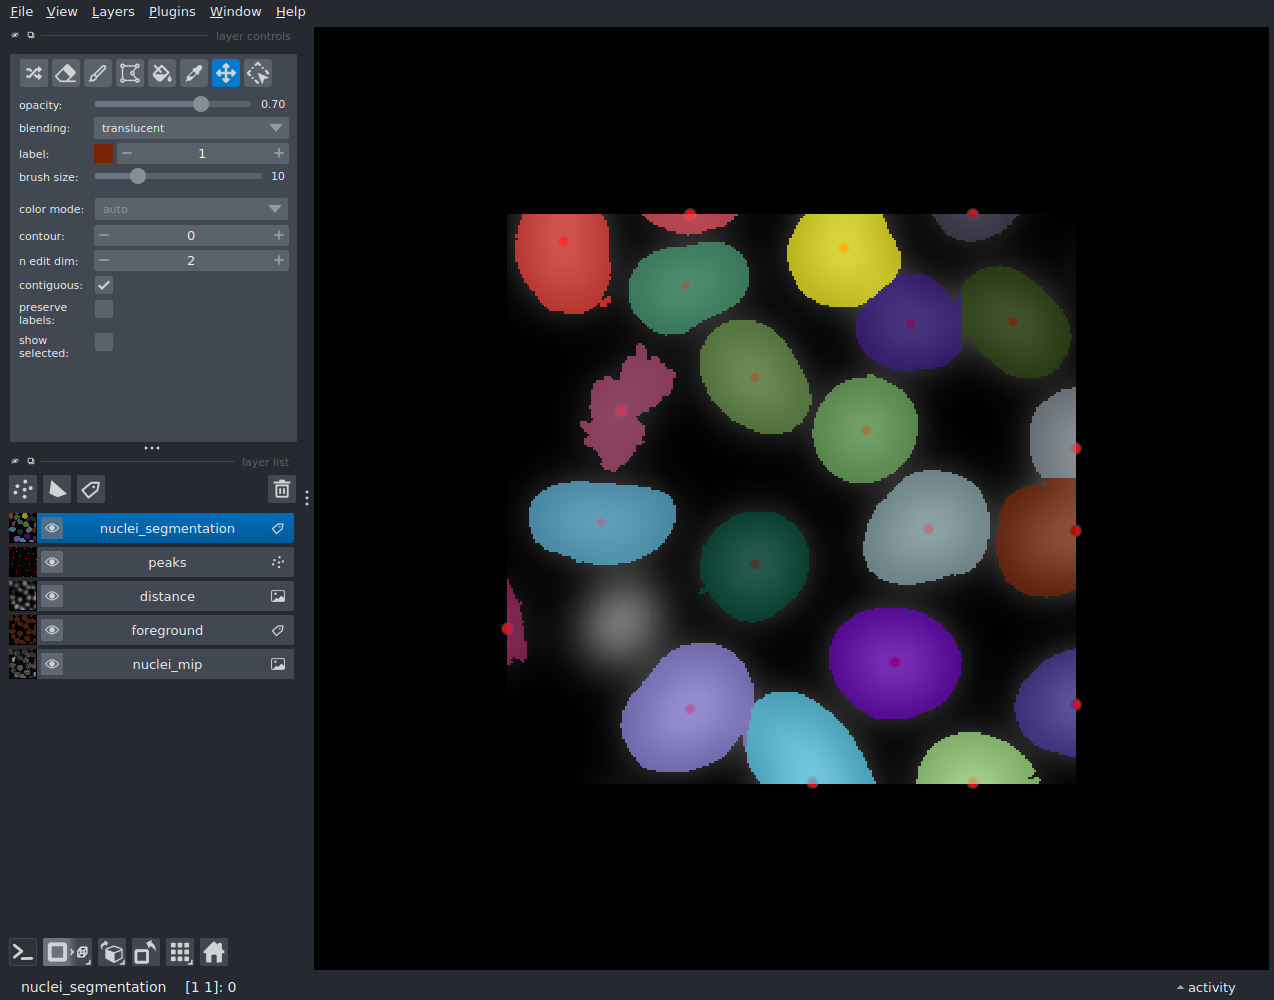

In [25]:
nbscreenshot(viewer)

We can now save our segmentation using our builtin save method.

In [26]:
viewer.layers['nuclei_segmentation'].save('nuclei-automated-segmentation.tif', plugin='builtins')

ValueError: There is no registered plugin named 'builtins'.
Plugins capable of writing layer._type_string layers are: set()

## Interactive thresholding with a custom GUI element

Interactivity can be greatly enhanced by custom GUI elements like sliders and push buttons, custom mouse functions, or custom keybindings (keyboard shortcuts). **[napari](https://napari.org/)** can easily be extended with these features, and a companion library **[magicgui](https://magicgui.readthedocs.io/en/latest/)** maintained by the napari team allows users to make extensions to the GUI without having to write any GUI code.

We'll now explore adding such interactivity to **napari**.

In [ ]:
# Remove all processed layers
for l in viewer.layers[1:]:
    viewer.layers.remove(l)

In [ ]:
# Import magicgui
from magicgui import magicgui

In [ ]:
from napari.types import ImageData, LabelsData

@magicgui(auto_call=True,
          percentile={"widget_type": "IntSlider", "min": 0, "max": 100})
def threshold(image: ImageData, percentile: int = 50) -> LabelsData:
    data_min = np.min(image)
    data_max = np.max(image)
    return image > data_min + percentile / 100 * (data_max - data_min)

In [ ]:
viewer.window.add_dock_widget(threshold, area="right")

In [ ]:
nbscreenshot(viewer)

## Adding a custom keybinding to the viewer for processing foreground data

In [ ]:
@viewer.bind_key('Shift-P')
def process_foreground(viewer):
    data = viewer.layers['threshold result'].data
    data_processed = morphology.remove_small_holes(np.bool(data), 60)
    data_processed = morphology.remove_small_objects(data_processed, min_size=50)
    viewer.layers['threshold result'].data = data_processed

In [ ]:
process_foreground(viewer)

In [ ]:
nbscreenshot(viewer)

In [ ]:
# Add an empty labels layer with the same shape as our maximum intensity projection
viewer.add_labels(np.zeros(nuclei_mip.shape, dtype=int), name='nuclei segmentation')

In [ ]:
# Bind another keybinding to complete segmentation
@viewer.bind_key('Shift-S')
def complete_segmentation(viewer):
    foreground = viewer.layers['threshold result'].data
    distance = ndimage.distance_transform_edt(foreground)
    smoothed_distance = filters.gaussian(distance, 10)
    peak_local_max = feature.peak_local_max(
        smoothed_distance,
        min_distance=7,
        exclude_border=False
    )
    markers = util.label_points(peak_local_max, output_shape=foreground.data.shape)

    nuclei_segmentation = segmentation.watershed(
        -smoothed_distance, 
        markers, 
        mask=foreground
    )
    viewer.layers['nuclei segmentation'].data = nuclei_segmentation

In [ ]:
image_data = viewer.layers['nuclei_mip'].data
thresholded = image_data > image_data.min() + 12 / 100 * (image_data.max() - image_data.min())
viewer.layers['threshold result'].data = thresholded
process_foreground(viewer)
complete_segmentation(viewer)

In [ ]:
nbscreenshot(viewer)

## Conclusions

We've now seen how to interactively perform analyses by adding data to the napari viewer, and editing it as we moved through an analysis workflow. We've also seen how to extend the viewer with custom GUI functionality and keybindings, making analyses even more interactive!